## Sentiment Prediction Modeling

### Determining production model: Evaluating performance of LSTM RNN model, Logistic Regression model, Multinomial Naive Bayes model to determine which is the best model

Having gathered the posts by scraping, a sample of 1000 posts were labelled manually so as to train models to subsequently predict labels on the remainder of the dataset (around 9000 posts). *Textblob and VADER (unsupervised learning text classification models) were initially used to predict the sentiment of the posts, but the results were not accurate*

The labels are: 
- **0 for negative sentiment** 
- **1 for neutral sentiment**
- **2 for positive sentiment**

It should be noted that the labels were highly skewed, with around 80% of the posts classed as neutral, 15% as negative and 5% positive. This affected how well the model was able to predict the sentiment of unlabelled posts. 

The models chosen were classification models - Logistic Regression and Multinomial Naive Bayes, Long Short Term Memory Recurrent Neural Net model and BERT. 

It was found that the Multinomial Naive Bayes model was the most accurate in predicting sentiment. It had high Accuracy, ROC AUC and F1 scores, with little variance between the train and validation sets, as well as being more likely to assign minority classes, compared to the Logistic Regression Model. The performance of LSTM RNN and BERT models paled in comparison as well. For BERT, it could be that the pretrained model did not generalise well on the dataset, due to the nature of the local Singlish language (in terms of different words and sentence structures). The LSTM RNN model also did not do well, as it relied on learning words before and after a significant word, instead of standalone words, which did not work particularly well for this dataset.  

It should be noted that methods such as SMOTE, random oversampling and manipulating class weights were used to try to address the issue of unbalanced classes in the data, all of which did not perform as well as a model where the minority classes were not oversampled/given more weightage in the model. 

The process of labelling posts using a Supervised Learning model went as follows:
1. Split all posts into train (8214 posts) and test (2056 posts) sets 
2. From train set, manually label sentiment of first 1000 posts 
3. Trained first 1000 labelled posts on Multinomial NB model 
4. Predict label for next 1000 unlabelled posts 
5. Check for accuracy and make changes to incorrect labels 
6. Collate labelled posts and train model  
7. Label subsequent 1000 posts 
8. Repeat steps 3 to 7 until all of train posts (8214 posts) have been labelled 
9. Train Multinomial NB model on all posts in train set, which have been labelled 
10. Predict label on posts in test set 
11. Check accuracy of predictions and make changes to incorrect labels 
12. Collate labelled posts in train and test sets to train final production model **(THIS NOTEBOOK)** 

While I acknowledge that it is not ideal to use a regular supervised learning classification models to predict the sentiment of text posts, this was the best method for this particular dataset. I believe that with more data gathered, a LSTM RNN or BERT model can be sufficiently trained to better predict sentiment of posts from Singaporean forums.  

---
## Importing of libraries, train and test datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Embedding, SpatialDropout1D, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

In [3]:
train = pd.read_csv('./labelled_posts/train_labelled_clean.csv')
train.head()

,Unnamed: 0,post,label,date,source,post_clean_for_rnn
0,0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...
1,1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...
2,2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,only iq lower than 86 will believe this csb wh...
3,3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,i work nearby to the westlite and toh guan dor...
4,4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh liao


In [4]:
train.drop(columns = ['Unnamed: 0'], inplace=True)
display(train.isnull().sum())
train.fillna('nopost', inplace=True)
train.head(2)

post                  0
label                 0
date                  0
source                0
post_clean_for_rnn    5
dtype: int64

,post,label,date,source,post_clean_for_rnn
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...


In [5]:
test = pd.read_csv('./labelled_posts/test_posts_labelled_checked.csv')
test.head()

,post,label,date,source,post_clean
0,Need more camp to house all foreign worker,1,2020-04-15 15:09:00,hardwarezone,need camp house
1,Im interested in the clusters esp new ones. Wh...,1,2020-04-29 23:07:00,hardwarezone,im interested clusters esp new ones see
2,did the virus make his kkj buay kia?,1,2020-04-23 21:22:00,hardwarezone,make kkj buay kia
3,I’m not saying there isn’t room for improvemen...,1,2020-04-08 11:23:23,reddit,not saying room improvement point choice nsfs ...
4,abnn good life no need work get paid and free ...,1,2020-04-05 13:04:00,hardwarezone,abnn good life no need work get paid free food...


In [6]:
display(test.isnull().sum())
test.fillna('nopost', inplace=True)
test.head(2)

post          0
label         0
date          0
source        0
post_clean    8
dtype: int64

,post,label,date,source,post_clean
0,Need more camp to house all foreign worker,1,2020-04-15 15:09:00,hardwarezone,need camp house
1,Im interested in the clusters esp new ones. Wh...,1,2020-04-29 23:07:00,hardwarezone,im interested clusters esp new ones see


---
## Preprocessing of posts in train and test sets

### Preprocessing train posts - for classification models, logreg and multinomial naive bayes 

Preprocessing for RNN model already done

In [7]:
#dealing with stopwords 

#first cut - removing words from stopwords that indicate sentiment 
remove_words = ["no", "not", "against", "don't", "should", "should've", "couldn", "couldn't",'didn', "didn't",
                   'doesn',"doesn't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",
                   'wouldn',"wouldn't"]
stopwords = [word for word in stopwords.words('english') if word not in remove_words]
print(len(stopwords))

#also adding words that are either common words, singaporean slang or noisy words from forum posts
add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'dorm', 'dorms', 'dormitory', 'dormitories', 'covid', 
             '19', 'cases', 'virus', 'coronavirus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
            'xiaomi', 'l21a', '32']
stopwords.extend(add_words)
len(stopwords)

157


181

In [8]:
def preprocess(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
    
   #remove stopwords 
    no_stop = [word for word in tokens if word not in stopwords]

    no_stopword = (' '.join(no_stop))
        
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in no_stopword]
    
    #return words as a single string 
    return(''.join(lem))

In [9]:
post_clean = []

for p in train["post"]:
    post_clean.append(preprocess(p))

print(f"checking post_clean: \n{post_clean[0:5]}")

train['post_clean_nb_logreg'] = post_clean
train.head(10)

checking post_clean: 
['no new cluster beside two days', 'consistency accuracy could easier use data new moh situation report separates non foreigners citizen pr think count named clusters either linked construction sites live non cluster get categorized linked clusters pending investigations respectively moh situation report 28 3 10 4 ltp holders 545 linked clusters 126 linked clusters 141 pending investigations whereas estimate time period 702 construction related reason make graphs really 2 separate problems singapore circuit breaker slow growth general public stopping work construction sites circuit breaker doesn help construction site problem construction site problem tackled improving living conditions testing separating sick well conversely issues way many people exercising eating hawker centres sneakily meeting etc affect non problem yes testing situation worrisome not know prioritizing tests would political suicide moh admit either prioritizing sc pr first patriotism urgent se

,post,label,date,source,post_clean_for_rnn,post_clean_nb_logreg
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,only iq lower than 86 will believe this csb wh...,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,i work nearby to the westlite and toh guan dor...,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh liao,ho seh
5,I’m not saying we caused this spread among the...,0.0,2020-04-16 23:59:35,reddit,i m not saying we caused this spread among the...,not saying caused spread among agree oversight...
6,1. From healthy no wear mask to Mask mandatory...,0.0,2020-04-14 20:29:00,hardwarezone,1 from healthy no wear mask to mask mandatory ...,1 healthy no wear mask mask mandatory 2 many 9...
7,Exactly. People don’t even wanna let our publi...,2.0,2020-05-27 20:28:30,reddit,exactly people don t even wanna let our public...,exactly people even wanna let public servants ...
8,The current situation is beyond this woman. 24...,1.0,2020-06-06 14:40:00,sgtalk,the current situation is beyond this woman 24h...,current situation beyond woman 24hrs day not e...
9,"Iran, followed by China, India, Israel, Saudi ...",0.0,2020-04-23 17:52:00,hardwarezone,iran followed by china india israel saudi arab...,iran followed china india israel saudi arabia ...


### Preprocessing for test posts - for Recurrent Neural Network model 

Preprocessing for classification models - logreg and multinomial naive bayes already done

In [10]:
# will not remove stop words to help with sequentiality 

def preprocess_rnn(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
 
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in tokens]
    
    #return words as a single string 
    return(' '.join(lem))

In [11]:
post_clean_for_rnn = []

for p in test["post"]:
    post_clean_for_rnn.append(preprocess_rnn(p))

print(f"checking post_clean_for_rnn: \n{post_clean_for_rnn[1:3]}")

test['post_clean_for_rnn'] = post_clean_for_rnn
test.head(10)

checking post_clean_for_rnn: 
['im interested in the cluster esp new one where can i see', 'did the virus make his kkj buay kia']


,post,label,date,source,post_clean,post_clean_for_rnn
0,Need more camp to house all foreign worker,1,2020-04-15 15:09:00,hardwarezone,need camp house,need more camp to house all foreign worker
1,Im interested in the clusters esp new ones. Wh...,1,2020-04-29 23:07:00,hardwarezone,im interested clusters esp new ones see,im interested in the cluster esp new one where...
2,did the virus make his kkj buay kia?,1,2020-04-23 21:22:00,hardwarezone,make kkj buay kia,did the virus make his kkj buay kia
3,I’m not saying there isn’t room for improvemen...,1,2020-04-08 11:23:23,reddit,not saying room improvement point choice nsfs ...,i m not saying there isn t room for improvemen...
4,abnn good life no need work get paid and free ...,1,2020-04-05 13:04:00,hardwarezone,abnn good life no need work get paid free food...,abnn good life no need work get paid and free ...
5,I have some information that some of these cb ...,1,2020-04-14 20:23:00,hardwarezone,information cb companies already pulled house ...,i have some information that some of these cb ...
6,"A total of 122 are still unlinked, pending con...",1,2020-04-14 20:26:00,hardwarezone,total 122 still unlinked pending contact traci...,a total of 122 are still unlinked pending cont...
7,Case 1121 Mr.Worldwide,1,2020-04-04 21:53:14,reddit,case 1121 mr worldwide,case 1121 mr worldwide
8,I expect another national broadcast in 1 weeks...,1,2020-05-04 19:20:00,hardwarezone,expect another national broadcast 1 weeks time...,i expect another national broadcast in 1 week ...
9,"Even if not govt's fault, they took their eyes...",0,2020-04-17 16:56:00,sgtalk,even not govt fault took eyes ball not sure cl...,even if not govt s fault they took their eye o...


In [12]:
# renaming and reordering columns in test set 

test.rename(columns = {'post_clean': 'post_clean_nb_logreg',
                      'post_clean_for_rnn': 'post_clean_rnn'}, inplace=True)
test = test[['post', 'label', 'date', 'source', 'post_clean_rnn', 'post_clean_nb_logreg']]
display(test.shape)
test.head(2)

(2055, 6)

,post,label,date,source,post_clean_rnn,post_clean_nb_logreg
0,Need more camp to house all foreign worker,1,2020-04-15 15:09:00,hardwarezone,need more camp to house all foreign worker,need camp house
1,Im interested in the clusters esp new ones. Wh...,1,2020-04-29 23:07:00,hardwarezone,im interested in the cluster esp new one where...,im interested clusters esp new ones see


In [13]:
# renaming columns in train set 
train.rename(columns = {'post_clean_for_rnn': 'post_clean_rnn'}, inplace=True)
display(train.shape)
train.head(2)

(8213, 6)

,post,label,date,source,post_clean_rnn,post_clean_nb_logreg
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...,consistency accuracy could easier use data new...


### Merging train and test data 

In [14]:
all_posts = pd.concat([train, test], axis = 0, ignore_index=True)
display(all_posts.shape)
all_posts.head()

(10268, 6)

,post,label,date,source,post_clean_rnn,post_clean_nb_logreg
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,only iq lower than 86 will believe this csb wh...,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,i work nearby to the westlite and toh guan dor...,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh liao,ho seh


In [15]:
all_posts['label'].value_counts()

1.0    8907
0.0    1120
2.0     241
Name: label, dtype: int64

In [18]:
#export allposts 

all_posts.to_csv('./labelled_posts/all_posts_labelled.csv', index = False)

---
## Evaluating performance of RNN model on entire dataset

In [32]:
#Vectorize post text, by turning each text into either a sequence of integers or into a vector

# The maximum number of words to be used. (most frequent)
max_nb_words = 50000

# Max number of words in each complaint.
max_seq_length = 512

# This is fixed.
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(all_posts['post_clean_rnn'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17458 unique tokens.


In [33]:
#truncate and pad 
X = tokenizer.texts_to_sequences(all_posts['post_clean_rnn'].values)
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10268, 512)


In [34]:
#one hot encoding labels 
y = pd.get_dummies(all_posts['label']).values
y.shape

(10268, 3)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, 
                                                 stratify = y, random_state = 42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(8214, 512) (8214, 3)
(2054, 512) (2054, 3)


In [36]:
# Scale
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [37]:
model = Sequential()
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 512, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1

In [39]:
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data = (X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
                   verbose=1)

Epoch 1/20
257/257 [==============================] - 656s 3s/step - loss: 0.4759 - auc: 0.9203 - val_loss: 0.4523 - val_auc: 0.9265
Epoch 2/20
257/257 [==============================] - 710s 3s/step - loss: 0.4742 - auc: 0.9208 - val_loss: 0.4573 - val_auc: 0.9248
Epoch 3/20
257/257 [==============================] - 629s 2s/step - loss: 0.4700 - auc: 0.9217 - val_loss: 0.4526 - val_auc: 0.9259
Epoch 4/20
257/257 [==============================] - 729s 3s/step - loss: 0.4695 - auc: 0.9218 - val_loss: 0.4538 - val_auc: 0.9243


65/65 [==============================] - 22s 336ms/step - loss: 0.4538 - auc: 0.9243
Test set
  Loss: 0.454
  Accuracy: 0.924


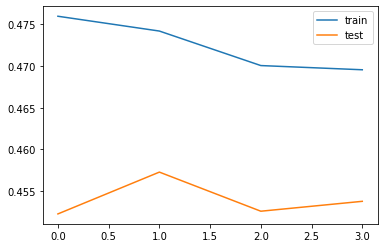

In [40]:
acc = model.evaluate(X_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  ROC AUC: {:0.3f}'.format(acc[0],acc[1]))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

---
## Evaluating performance of Logistic Regression Model on entire dataset

In [41]:
X = all_posts['post_clean_nb_logreg']
y = all_posts['label']

#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    stratify=y, 
                                                    random_state = 42)

In [42]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'cvec__max_features': [100, 200, 500],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [0.2, 0.3, 0.7],
    'cvec__ngram_range': [(1,1)],
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(-5, 1, 10)
}

gscv_lr = GridSearchCV(pipe, pipe_params, cv=5, n_jobs =-1, verbose=1)
gscv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 11.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.2, 0.3, 0.7],
                         'cvec__max_features': [100, 200, 500],
                         'cvec__min_df': [2, 4, 6],
                         'cvec__ngram_range': [(1, 1)],
                         'lr__C': array([1.00000000e-05, 4.64158883e-05, 2.15443469e-04, 1.00000000e-03,
       4.64158883e-03, 2.15443469e-02, 1.00000000e-01, 4.64158883e-01,
       2.15443469e+00, 1.00000000e+01]),
                         'lr__penalty': ['l1']},
             verbose=1)

In [43]:
gscv_lr.best_params_

{'cvec__max_df': 0.2,
 'cvec__max_features': 200,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.1,
 'lr__penalty': 'l1'}

In [44]:
#fitting model with optimised params 
opt_gscv_lr = gscv_lr.best_estimator_
opt_gscv_lr.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=200, min_df=4)),
                ('lr',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])

In [45]:
#create dataframe of performance metrics based on optimised model 
opt_results_lr = pd.DataFrame()

opt_results_lr['model'] = ['cvec + logistic regression']
opt_results_lr['optimised_params'] = [gscv_lr.best_params_]
opt_results_lr['train_acc_score'] = opt_gscv_lr.score(X_train, y_train)
opt_results_lr['test_acc_score'] = opt_gscv_lr.score(X_test, y_test)

pred_proba = opt_gscv_lr.predict_proba(X_test)
opt_results_lr['roc_auc_score'] = roc_auc_score(y_test, pred_proba, multi_class="ovo", average = 'weighted')
opt_results_lr['train_f1_score'] = f1_score((opt_gscv_lr.predict(X_train)), y_train, average = 'weighted')
opt_results_lr['test_f1_score'] = f1_score((opt_gscv_lr.predict(X_test)), y_test, average = 'weighted')

display(opt_results_lr)

#confusion matrix for logreg

y_pred_lr = opt_gscv_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm,
                     index = ['actual 0','actual 1','actual 2'], 
                     columns = ['pred 0','pred 1','pred 2'])
display(cm_df)

print(classification_report(y_test, y_pred_lr, digits=3))

,model,optimised_params,train_acc_score,test_acc_score,roc_auc_score,train_f1_score,test_f1_score
0,cvec + logistic regression,"{'cvec__max_df': 0.2, 'cvec__max_features': 20...",0.874604,0.872931,0.785813,0.916755,0.914799


,pred 0,pred 1,pred 2
actual 0,25,197,2
actual 1,14,1767,1
actual 2,8,39,1


              precision    recall  f1-score   support

         0.0      0.532     0.112     0.185       224
         1.0      0.882     0.992     0.934      1782
         2.0      0.250     0.021     0.038        48

    accuracy                          0.873      2054
   macro avg      0.555     0.375     0.386      2054
weighted avg      0.829     0.873     0.831      2054



---
## Evaluating performance of Multinomial Naive Bayes Model on entire dataset

In [142]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])


pipe_params = {
    'cvec__max_features': [500],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [0.2, 0.3, 0.5, 0.7],
    'cvec__ngram_range': [(1,2)]}


gscv_nb = GridSearchCV(pipe, pipe_params, cv=5, n_jobs =-1, verbose=1)
gscv_nb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   22.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.2, 0.3, 0.5, 0.7],
                         'cvec__max_features': [500], 'cvec__min_df': [2, 4, 6],
                         'cvec__ngram_range': [(1, 2)]},
             verbose=1)

In [143]:
gscv_nb.best_params_

{'cvec__max_df': 0.2,
 'cvec__max_features': 500,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2)}

In [144]:
#fitting model with optimised params 
opt_gscv_nb = gscv_nb.best_estimator_
opt_gscv_nb.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=500, min_df=4,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [109]:
#create dataframe of metrics based on optimised model 
opt_results_nb = pd.DataFrame()

opt_results_nb['model'] = ['cvec + multinomial nb']
opt_results_nb['optimised_params'] = [gscv_nb.best_params_]
opt_results_nb['train_acc_score'] = opt_gscv_nb.score(X_train, y_train)
opt_results_nb['test_acc_score'] = opt_gscv_nb.score(X_test, y_test)

pred_proba = opt_gscv_nb.predict_proba(X_test)
opt_results_nb['roc_auc_score'] = roc_auc_score(y_test, pred_proba, multi_class="ovo", average = 'weighted')
opt_results_nb['train_f1_score'] = f1_score((opt_gscv_nb.predict(X_train)), y_train, average = 'weighted')
opt_results_nb['test_f1_score'] = f1_score((opt_gscv_nb.predict(X_test)), y_test, average = 'weighted')

display(opt_results_nb)

#confusion matrix and classification report for multinomial nb 

y_pred_nb = opt_gscv_nb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_nb)
cm_df = pd.DataFrame(cm,
                     index = ['actual 0','actual 1','actual 2'], 
                     columns = ['pred 0','pred 1','pred 2'])
display(cm_df)
print('')
print(classification_report(y_test, y_pred_nb, digits=3))

,model,optimised_params,train_acc_score,test_acc_score,roc_auc_score,train_f1_score,test_f1_score
0,cvec + multinomial nb,"{'cvec__max_df': 0.2, 'cvec__max_features': 50...",0.8701,0.869036,0.727923,0.875525,0.877433


,pred 0,pred 1,pred 2
actual 0,80,133,11
actual 1,65,1692,25
actual 2,10,25,13



              precision    recall  f1-score   support

         0.0      0.516     0.357     0.422       224
         1.0      0.915     0.949     0.932      1782
         2.0      0.265     0.271     0.268        48

    accuracy                          0.869      2054
   macro avg      0.565     0.526     0.541      2054
weighted avg      0.856     0.869     0.861      2054



---
## Production Model

Chose multinomial naive bayes model - low variance for accuracy scores and f1-scores, predicted minority classes more accurately than logreg

In [110]:
production_model = opt_gscv_nb.fit(X, y)
production_model

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.2, max_features=500, min_df=2)),
                ('nb', MultinomialNB())])

---
## Model Insights

### Interpreting coefficients from Multinomial NB model 

Upside of using a classification model instead of neural network - interpretability. 

Words with smallest negative coefficient values have the LEAST IMPACT in lowering the probability of the class, more likely that a word indicates negative, neutral or positive sentiment.

Words with largest negative coefficient values have the MOST IMPACT in lowering the probability of the class, less likely that a word indicates negative, neutral or positive sentiment. 

In [157]:
coefs = opt_gscv_nb.named_steps['nb'].coef_
display(coefs.shape)

features = opt_gscv_nb.named_steps['cvec'].get_feature_names()
display(len(features))

#creating dataframe of words and coefficients for each class
coef_df = pd.DataFrame({'word':features, 
                        'coef_negative_class':coefs[0], 
                        'coef_neutral_class':coefs[1], 
                        'coef_positive_class':coefs[2]})
coef_df.head()

(3, 500)

500

,word,coef_negative_class,coef_neutral_class,coef_positive_class
0,000,-6.169192,-5.618496,-6.053970
1,10,-6.113622,-5.880141,-6.970260
2,100,-6.780101,-6.630997,-6.816110
3,12,-7.778630,-6.746308,-7.375726
4,120,-7.778630,-6.827277,-8.762020


Negative class words not too dissimilar from positive class words. 

Exceptions are calling out organisations and agencies in their posts - 'PAP' (People's Action Party - the ruling party) and 'MOM' (Ministry of Manpower), perhaps 

The word 'still' indicates a sentiment in these posts that COVID-19 cases in dorms remain high. 

'Mask' is also another word in negative sentiment posts - perhaps taking issue with the Government's delay in asking people to wear masks in public. 

In [148]:
coef_df.sort_values(by ='coef_negative_class',ascending=False)[0:20]

,word,coef_negative_class,coef_neutral_class,coef_positive_class
292,no,-4.156196,-4.352461,-4.355301
234,like,-4.451541,-4.491513,-4.527913
170,government,-4.493432,-5.572794,-4.367571
311,pap,-4.493432,-6.394087,-5.989431
319,people,-4.542757,-4.515099,-4.197672
301,one,-4.618595,-4.595838,-4.667675
388,should,-4.636944,-4.909292,-4.572365
276,mom,-4.775780,-6.081331,-6.816110
286,need,-4.782898,-4.821248,-5.206672
372,said,-4.834191,-4.620725,-4.870200


For words indicating positive classes

Words like 'people', 'government', 'singapore' are top words indicating positive sentiment - similar to negative sentiment coefficients but of more importance

'Would', 'should' - indicating some kind of suggestion in the post, hence will do topic modelling in next section

'Good' also in top words, but not a very large negative coefficient, suggestion other words are more prominent in positive sentiment posts

In [149]:
coef_df.sort_values(by ='coef_positive_class',ascending=False)[0:20]

,word,coef_negative_class,coef_neutral_class,coef_positive_class
319,people,-4.542757,-4.515099,-4.197672
292,no,-4.156196,-4.352461,-4.355301
170,government,-4.493432,-5.572794,-4.367571
20,also,-4.962366,-4.690760,-4.471561
493,would,-5.149829,-4.967596,-4.471561
392,singapore,-4.912356,-4.432673,-4.471561
234,like,-4.451541,-4.491513,-4.527913
388,should,-4.636944,-4.909292,-4.572365
440,think,-5.080149,-4.803577,-4.603137
301,one,-4.618595,-4.595838,-4.667675


### Proportion of negative/neutral/positive sentiment posts per source 

#### Reddit
- Negative sentiment posts: 247 of 3493 posts (7.08%)
- Neutral sentiment posts: 3109 of 3493 posts (89%)
- Positive sentiment posts 137 of 3493 posts (3.92%)

#### Hardwarezone 
- Negative sentiment posts: 673 of 6081 posts (11%)
- Neutral sentiment posts: 5318 of 6081 posts (87.5%)
- Positive sentiment posts: 90 of 6081 posts (1.5%)

#### Sgtalk
- Negative sentiment posts: 200 of 694 posts (28%)
- Neutral sentiment posts: 480 of 694 posts (70%)
- Positive sentiment posts 14 of 694 posts (2%)

In [139]:
all_posts['source'].value_counts()

hardwarezone    6081
reddit          3493
sgtalk           694
Name: source, dtype: int64

In [154]:
#positive/neutral/neg posts skewed to which source?

#REDDIT
print('**********REDDIT**********')
print('')
print('reddit posts with negative sentiment')
display(all_posts[all_posts['label'] == 0][all_posts['source'] == 'reddit'].count())

print('reddit posts with neutral sentiment')
display(all_posts[all_posts['label'] == 1][all_posts['source'] == 'reddit'].count())

print('reddit posts with positive sentiment')
display(all_posts[all_posts['label'] == 2][all_posts['source'] == 'reddit'].count())

#HARDWAREZONE
print('**********HARDWAREZONE**********')
print('')
print('hardwarezone posts with negative sentiment')
display(all_posts[all_posts['label'] == 0][all_posts['source'] == 'hardwarezone'].count())

print('hardwarezone posts with neutral sentiment')
display(all_posts[all_posts['label'] == 1][all_posts['source'] == 'hardwarezone'].count())

print('hardwarezone posts with positive sentiment')
display(all_posts[all_posts['label'] == 2][all_posts['source'] == 'hardwarezone'].count())

#SGTALK
print('**********SGTALK**********')
print('')
print('sgtalk posts with negative sentiment')
display(all_posts[all_posts['label'] == 0][all_posts['source'] == 'sgtalk'].count())

print('sgtalk posts with neutral sentiment')
display(all_posts[all_posts['label'] == 1][all_posts['source'] == 'sgtalk'].count())

print('sgtalk posts with positive sentiment')
display(all_posts[all_posts['label'] == 2][all_posts['source'] == 'sgtalk'].count())

**********REDDIT**********

reddit posts with negative sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


post                    247
label                   247
date                    247
source                  247
post_clean_rnn          247
post_clean_nb_logreg    247
dtype: int64

reddit posts with neutral sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


post                    3109
label                   3109
date                    3109
source                  3109
post_clean_rnn          3109
post_clean_nb_logreg    3109
dtype: int64

reddit posts with positive sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


post                    137
label                   137
date                    137
source                  137
post_clean_rnn          137
post_clean_nb_logreg    137
dtype: int64

**********HARDWAREZONE**********

hardwarezone posts with negative sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


post                    673
label                   673
date                    673
source                  673
post_clean_rnn          673
post_clean_nb_logreg    673
dtype: int64

hardwarezone posts with neutral sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


post                    5318
label                   5318
date                    5318
source                  5318
post_clean_rnn          5318
post_clean_nb_logreg    5318
dtype: int64

hardwarezone posts with positive sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


post                    90
label                   90
date                    90
source                  90
post_clean_rnn          90
post_clean_nb_logreg    90
dtype: int64

**********SGTALK**********

sgtalk posts with negative sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


post                    200
label                   200
date                    200
source                  200
post_clean_rnn          200
post_clean_nb_logreg    200
dtype: int64

sgtalk posts with neutral sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


post                    480
label                   480
date                    480
source                  480
post_clean_rnn          480
post_clean_nb_logreg    480
dtype: int64

sgtalk posts with positive sentiment


/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


post                    14
label                   14
date                    14
source                  14
post_clean_rnn          14
post_clean_nb_logreg    14
dtype: int64

In [156]:
# num of positive/neg posts evolved over time? 
# unable to generate insights as many post dates were incorrectly labelled by the source 

all_posts['date'].unique()

array(['2020-10-04 08:34:00', '2020-04-11 12:26:38',
       '2020-04-23 10:42:00', ..., '2020-11-05 22:17:00',
       '2020-10-04 08:30:00', '2020-04-14 13:34:14'], dtype=object)